In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# Getting Started

In this notebook, we'll use a simple mask and correct for mode coupling.

In [2]:
import nawrapper.ps as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

Let's generate a random map to try doing analysis on.

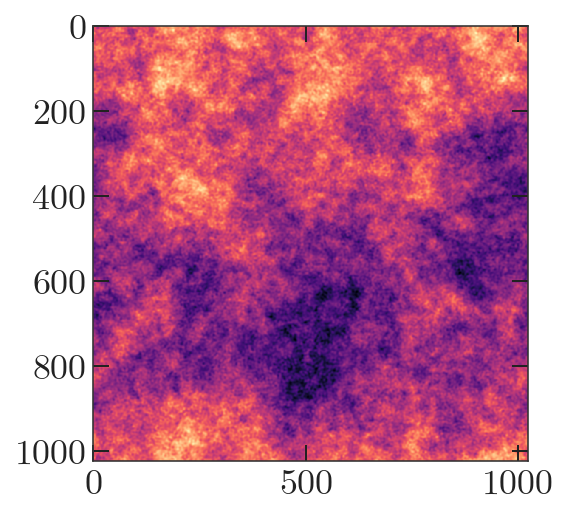

In [3]:
shape,wcs = enmap.geometry(shape=(1024,1024),res=np.deg2rad(0.5/60.),pos=(0,0))
ells = np.arange(0,6000,1)
ps = np.zeros(len(ells))
ps[1:] = 1/ells[1:]**2.5
ps[:2] = 0
imap = enmap.rand_map(shape,wcs,ps[None,None])
plt.imshow(imap)

Next, let's generate a point source map. We'll add these sources to the map, and apodize to generate a mask.

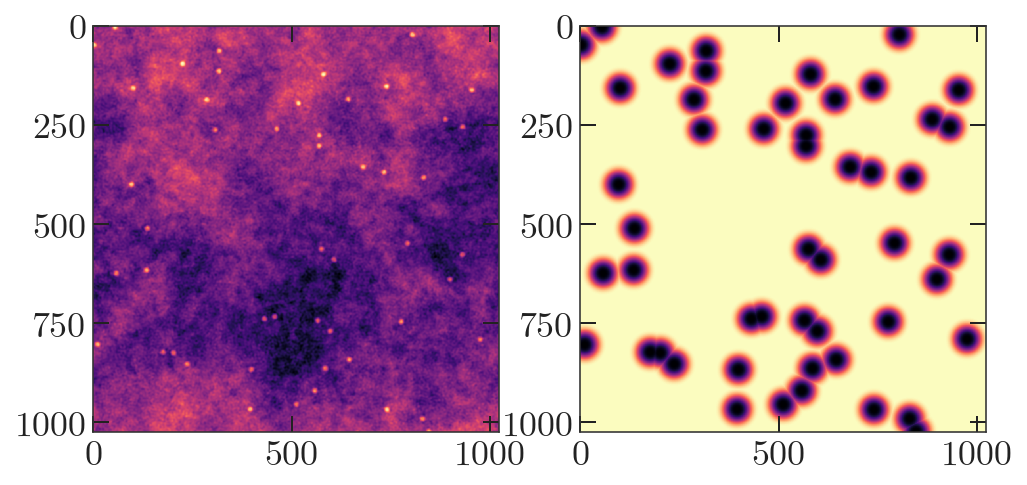

In [4]:
mask = enmap.ones(imap.shape, imap.wcs)

N_point_sources = 50
for i in range(N_point_sources):
    mask[ 
        np.random.randint(low=0, high=mask.shape[0]), 
        np.random.randint(low=0, high=mask.shape[1]) ] = 0

point_source_map = 1-nw.apod_C2(mask, 0.1)
imap += point_source_map
mask = nw.apod_C2(mask, 0.5)

fig, axes = plt.subplots(1, 2, figsize=(8,16))

axes[0].imshow(imap)
axes[1].imshow(mask)

Now let's do two noise realizations.

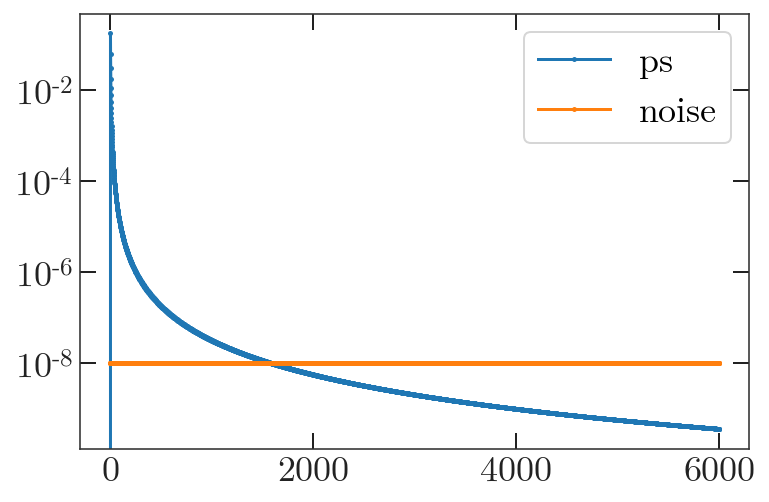

In [5]:
ells = np.arange(0,len(ps),1)
nl = np.ones(len(ells)) * 1e-8
plt.plot(ps, label="ps")
plt.plot(nl, label="noise")
plt.yscale('log')
plt.legend()

In [6]:
noise_map_1 = enmap.rand_map(shape,wcs,nl[None,None])
noise_map_2 = enmap.rand_map(shape,wcs,nl[None,None])

For this example we won't include a beam. Let's set up the namap objects.

# The Power Spectrum Part

In [7]:
namap_1 = nw.namap(map_I=imap + noise_map_1, mask=mask)
namap_2 = nw.namap(map_I=imap + noise_map_2, mask=mask)

Now let's compute the mode coupling matrix. We will need a binning file.

In [8]:
binfile = 'data/BIN_ACTPOL_50_4_SC_low_ell'
bins = nw.read_bins(binfile)
mc = nw.mode_coupling(namap_1, namap_2, bins)

Finally, we can compute some spectra!

In [9]:
Cb = nw.compute_spectra(namap_1, namap_2, mc=mc)
print(Cb)

{'TT': array([6.33845739e-05, 1.88543334e-06, 6.40777457e-06, 1.49562625e-06,
       1.51469495e-06, 8.50632048e-07, 5.52981820e-07, 4.00936397e-07,
       3.18154481e-07, 1.45920574e-07, 2.05399917e-07, 7.99298944e-08,
       1.12514701e-07, 3.80625831e-08, 7.83639957e-08, 5.68351387e-08,
       4.45708094e-08, 5.07061225e-08, 4.21886023e-08, 3.25123387e-08,
       2.56550459e-08, 2.22023183e-08, 2.70457605e-08, 2.41575122e-08,
       1.76275996e-08, 1.71734649e-08, 1.82915061e-08, 1.68179136e-08,
       1.22432487e-08, 1.33136007e-08, 1.12390130e-08, 1.09663901e-08,
       8.23319809e-09, 7.04820822e-09, 6.88557817e-09, 8.24612100e-09,
       9.24447352e-09, 8.33370820e-09, 6.08172284e-09, 7.87620065e-09,
       5.07347906e-09, 5.81854212e-09, 4.23305739e-09, 2.38717207e-09,
       3.49682074e-09, 3.09706230e-09, 2.53360767e-09, 2.00943147e-09,
       1.64756218e-09, 1.23859436e-09, 1.10320496e-09, 7.42946086e-10,
       5.68737757e-10, 4.16162656e-10, 3.68864488e-10, 1.51399872e-10]

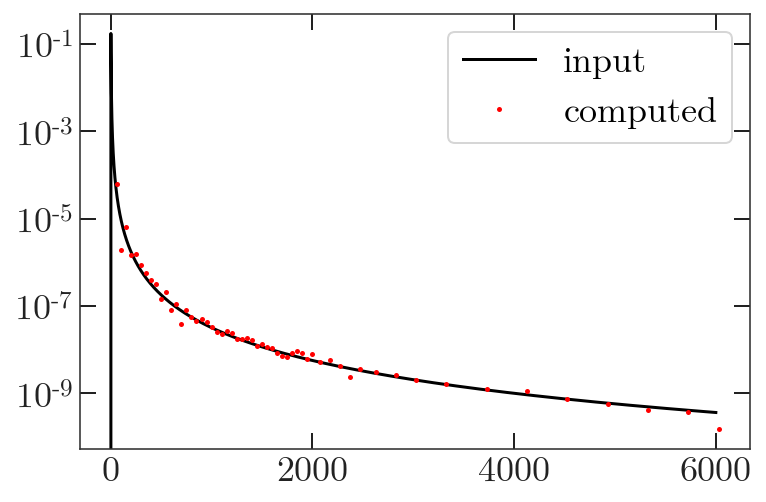

In [10]:
plt.plot(ps, 'k-', label='input')
plt.plot(Cb['ell'], Cb['TT'], 'r.', label='computed')
plt.legend()
plt.yscale('log')